https://www.kaggle.com/c/jovian-pytorch-z2g/discussion/163666

2(a) Second I used a complex classifier. In this I also replaced the adaptive pooling. (this approach is taken from protein-classification-one-cycle

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas/'
TRAIN_DIR = DATA_DIR + "/" + "train"
TEST_DIR = DATA_DIR + "/" + "test"
TRAIN_CSV = DATA_DIR +"/" + "train.csv"

# Data Loading and some helper functions

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [ ]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [ ]:
rev_labels = dict()
for key in labels.keys():
    rev_labels[labels[key]] = key

In [ ]:
rev_labels

{'Mitochondria': 0,
 'Nuclear bodies': 1,
 'Nucleoli': 2,
 'Golgi apparatus': 3,
 'Nucleoplasm': 4,
 'Nucleoli fibrillar center': 5,
 'Cytosol': 6,
 'Plasma membrane': 7,
 'Centrosome': 8,
 'Nuclear speckles': 9}

In [ ]:
def num_to_name(labels):
    return [labels[i] for i in labels]

In [ ]:
def name_to_num(labels):
    return [rev_labels[i] for i in labels]

In [ ]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
set_seed(17)

In [ ]:
def encode_labels(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

In [ ]:
def decode_labels(target, thresh=0.5, return_label=False):
    result = []
    for i, tgt in enumerate(target):
        if tgt > thresh:
            if return_label:
                result.append(str(i) + ":" + labels[i] + "/")
            else:
                result.append(str(i))
            
    return result

# Display Images

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [ ]:
def display_img(img, label=None, unnorm=False, unnorm_obj=None, invert=True, return_label=True):
    if unnorm and unnorm_obj != None:
        img = unnorm_obj(img)
    
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    
    if label != None:
        plt.title(decode_labels(label, return_label=return_label))

In [ ]:
def display_batch(batch, unnorm=False, unnorm_obj=None, invert=True):    
    imgs, labels = batch
    
    if unnorm and unnorm_obj:
        unnorm_imgs = []
        for img in imgs:
            if invert:
                unnorm_imgs.append(1 - unnorm_obj(img))
            else:
                unnorm_imgs.append(unnorm_obj(img))
        imgs = unnorm_imgs
    else:
        if invert:
            imgs = 1 - imgs
    
    ig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))

# Dataset

In [ ]:
class ProteinDataset(nn.Module):
    def __init__(self, root_dir, label_df, transforms=None):
        assert(os.path.exists(root_dir))
        self.root_dir = root_dir
        self.label_df = label_df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        row = self.label_df.loc[idx]
        img_id, label = row['Image'], row['Label']
        img = Image.open(self.root_dir + "/" + str(img_id) + ".png")
        if self.transforms:
            img = self.transforms(img)
        return img, encode_labels(label)

In [ ]:
'''
This code can be used to get mean and std of dataset

mean = 0.
std = 0.
nb_samples = 0.
for imgs, _ in loader:
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
'''

'\nThis code can be used to get mean and std of dataset\n\nmean = 0.\nstd = 0.\nnb_samples = 0.\nfor imgs, _ in loader:\n    batch_samples = imgs.size(0)\n    imgs = imgs.view(batch_samples, imgs.size(1), -1)\n    mean += imgs.mean(2).sum(0)\n    std += imgs.std(2).sum(0)\n    nb_samples += batch_samples\n\nmean /= nb_samples\nstd /= nb_samples\n'

In [ ]:
mean = [0.0793, 0.0530, 0.0545]
std = [0.1290, 0.0886, 0.1376]

In [ ]:
normalize = transforms.Normalize(mean=mean, std=std)

train_tf = transforms.Compose([
    transforms.RandomCrop(512, padding=8, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    normalize,
    transforms.RandomErasing(inplace=True)
])

test_tf = transforms.Compose([
    transforms.RandomCrop(512, padding=8, padding_mode='symmetric'),
    transforms.ToTensor(),
    normalize
])

In [ ]:
val_pct = 0.1

In [ ]:
msk = np.random.rand(len(train_df)) < (1- val_pct)

In [ ]:
train_split_df = train_df[msk].reset_index()
val_split_df = train_df[~msk].reset_index()

In [ ]:
len(train_split_df), len(val_split_df)

(17444, 1792)

In [ ]:
train_ds = ProteinDataset(TRAIN_DIR, train_split_df, train_tf)
valid_ds = ProteinDataset(TRAIN_DIR, val_split_df, test_tf)

In [ ]:
bs = 32

In [ ]:
train_loader = DataLoader(train_ds, bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, bs, num_workers=4, pin_memory=True)

In [ ]:
img, label = train_ds[0]

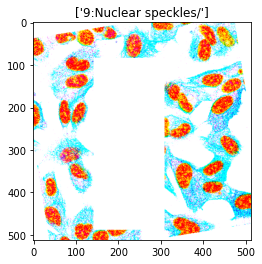

In [ ]:
display_img(img, label)

In [ ]:
unnorm = UnNormalize(mean, std)

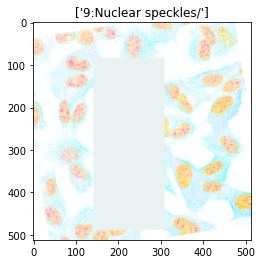

In [ ]:
display_img(img, label, unnorm=True, unnorm_obj=unnorm)

In [ ]:
batch = next(iter(train_loader))

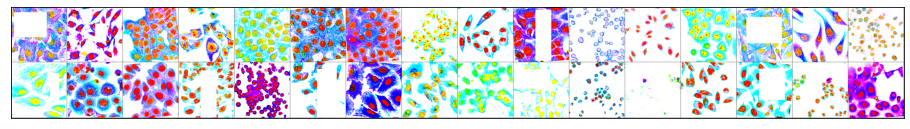

In [ ]:
display_batch(batch)

# F1 Score/Stats Function

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-15))
    recall = torch.mean(TP / (TP + FN + 1e-15))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-15)
    return F2.mean(0)

In [ ]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.F1 =[]
        self.its = []
        
    def append(self, loss, F1, it):
        self.losses.append(loss)
        self.F1.append(F1)
        self.its.append(it)

# CLR

(Github: https://github.com/nachiket273/One_Cycle_Policy)

In [ ]:
import math


class CLR(object):
    def __init__(self, optim, bn, base_lr=1e-7, max_lr=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.optim = optim
        self.bn = bn - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
        
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log')
        
        
    def plot_lr(self):
        plt.xlabel("Iterations")
        plt.ylabel("Learning Rate")
        plt.plot(self.lrs)
        plt.yscale('log')

# One Cycle Policy

(Github: https://github.com/nachiket273/One_Cycle_Policy)

In [ ]:
class OneCycle(object):
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10, div=10, use_cosine=False):
        self.nb = nb
        self.div = div
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.use_cosine = use_cosine
        if self.use_cosine:
            self.prcnt = 0
        else:
            self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        if self.use_cosine:
            self.step_len =  int(self.nb / 4)
        else:
            self.step_len =  int(self.nb * (1- prcnt/100)/2)
        
    def calc(self):
        if self.use_cosine:
            lr = self.calc_lr_cosine()
            mom = self.calc_mom_cosine()
        else:
            lr = self.calc_lr()
            mom = self.calc_mom()
        self.iteration += 1
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration ==  0:
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration == self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            #lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
            lr = (self.high_lr / self.div) * (1- ratio * (1 - 1/self.div))
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr

    def calc_mom(self):
        if self.iteration == 0:
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration == self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom

    def calc_lr_cosine(self):
        if self.iteration ==  0:
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration == self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/(self.nb - self.step_len)
            lr = (self.high_lr/self.div) + 0.5 * (self.high_lr - self.high_lr/self.div) * (1 + math.cos(math.pi * ratio))
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr - 0.5 * (self.high_lr - self.high_lr/self.div) * (1 + math.cos(math.pi * ratio))
        self.lrs.append(lr)
        return lr

    def calc_mom_cosine(self):
        if self.iteration == 0:
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration == self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/(self.nb - self.step_len)
            mom = self.high_mom - 0.5 * (self.high_mom - self.low_mom) * (1 + math.cos(math.pi * ratio))
        else :
            ratio = self.iteration/self.step_len
            mom = self.low_mom + 0.5 * (self.high_mom - self.low_mom) * (1 + math.cos(math.pi * ratio))
        self.moms.append(mom)
        return mom

# Save and load checkpoint

In [ ]:
def save_checkpoint(model, is_best, filename='data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [ ]:
def load_checkpoint(model, filename = 'data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()):
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

# AdaptiveConcatPool and custom classifier

In [ ]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.adavgp = nn.AdaptiveAvgPool2d(sz)
        self.adamaxp = nn.AdaptiveMaxPool2d(sz)
        
    def forward(self, x):
        x = torch.cat([self.adavgp(x), self.adamaxp(x)], 1)
        x = x.view(x.size(0),-1)
        return x

In [ ]:
class CustomClassifier(nn.Module):
    def __init__(self, in_features, intermed_bn= 512, out_features=10, dout=0.25):
        super().__init__()
        self.fc_bn0 = nn.BatchNorm1d(in_features)
        self.dropout0 = nn.Dropout(dout)
        self.fc0 = nn.Linear(in_features, intermed_bn, bias=True)
        self.fc_bn1 = nn.BatchNorm1d(intermed_bn, momentum=0.01)
        self.dropout1 = nn.Dropout(dout * 2)
        self.fc1 = nn.Linear(intermed_bn, out_features, bias=True)
        
    def forward(self, x):
        x = self.fc_bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc0(x))
        x = self.fc_bn1(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        return x

# Set optimizer/loss and find lr

In [ ]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [ ]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [ ]:
def find_lr(model, loader, device):
    t = tqdm(loader, leave=False, total=len(loader))
    running_loss = 0.
    avg_beta = 0.98
    model.train()
    for i, (ip, tgt) in enumerate(t):
        ip, tgt = ip.to(device), tgt.to(device)
        output = torch.sigmoid(model(ip))
        loss = criterion(output, tgt)

        running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)

        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(optimizer, lr)   

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
model = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.avgpool = AdaptiveConcatPool2d()
model.fc = CustomClassifier(in_features=model.fc.in_features*2, out_features=10)

In [ ]:
for param in model.parameters():
    param.require_grad = True
    
model = model.to(device)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [ ]:
save_checkpoint(model, True, 'init.pth')

In [ ]:
clr = CLR(optimizer, len(train_loader))

In [ ]:
find_lr(model, train_loader, device)

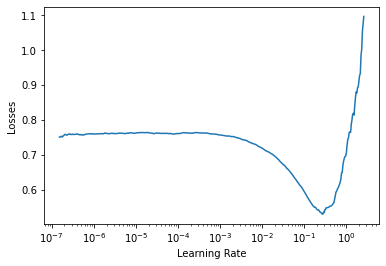

In [ ]:
clr.plot()

# Train and Test

In [ ]:
def train(epoch, model, optimizer, use_cycle=False, onecycle=None):
    model.train()
    global trn_F1, trn_losses, trn_time
    running_loss = 0.
    running_F1 = 0.
    
    start_time = time.time()
    
    t = tqdm(train_loader, leave=False, total=len(train_loader))

    for i, (ip, tgt) in enumerate(t):
        ip, tgt = ip.to(device), tgt.to(device)
        
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(optimizer, lr)
            update_mom(optimizer, mom)
                                    
        output = torch.sigmoid(model(ip))
        loss = criterion(output, tgt)
        running_loss += loss.item()
            
        # Append outputs
        running_F1 += F_score(tgt, output)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    trn_time = time.time() - start_time        
    trn_F1 = running_F1/len(train_loader)
    trn_losses = running_loss/len(train_loader)

In [ ]:
def test(model):
    with torch.no_grad():
        model.eval()
        global best_F1
        global val_F1, val_losses, val_time
        running_loss = 0.
        running_F1 = 0.
        start_time = time.time()
        
        t = tqdm(valid_loader, leave=False, total=len(valid_loader))
        
        for i, (ip, tgt) in enumerate(t):
            ip, tgt = ip.to(device), tgt.to(device)
            output = torch.sigmoid(model(ip))
            loss = criterion(output, tgt)
            running_loss += loss.item()
            running_F1 += F_score(tgt, output)
            
        val_time = time.time() - start_time
        F1_score = running_F1/len(valid_loader)
        if F1_score > best_F1:
            best_F1 = F1_score
            save_checkpoint(model, True, './best_model.pth')
            
        val_F1 = F1_score
        val_losses = running_loss/len(valid_loader)

In [ ]:
train_stats = AvgStats()
test_stats = AvgStats()

In [ ]:
best_F1 = 0
trn_time = 0
trn_losses = 0.0
trn_F1 = 0.0
val_losses = 0.0
val_F1 = 0.0
val_time = 0

In [ ]:
def fit(model, optimizer, epochs, sched=None, use_cycle=False, onecycle=None):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_F1\t\tVal_F1")
    for j in range(epochs):
        train(j, model, optimizer, use_cycle=use_cycle, onecycle=onecycle)
        train_stats.append(trn_losses, trn_F1, trn_time)
        test(model)
        test_stats.append(val_losses, val_F1, val_time)
        if sched:
            sched.step(j)
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_losses, val_losses, trn_F1, val_F1))

In [ ]:
epochs = 15

In [ ]:
load_checkpoint(model, 'init.pth')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [ ]:
ocp = OneCycle(int(len(train_ds) * epochs /bs), 1e-1, use_cosine=True)
#sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [ ]:
import time

In [ ]:
fit(model, optimizer, epochs, use_cycle=True, onecycle=ocp)

Epoch	Trn_loss	Val_loss	Trn_F1		Val_F1


1	0.36741001	0.25950345	0.49771816	0.58995134


2	0.26018098	0.26673441	0.62216705	0.59165412


3	0.24434600	0.22388746	0.65551054	0.67512637


4	0.23033157	0.23661960	0.68472248	0.70496041


5	0.21788720	0.24000172	0.70127046	0.60855246


6	0.20737249	0.20519083	0.71469915	0.73342103


7	0.19884121	0.21606863	0.73026621	0.68826264


8	0.19351969	0.20674446	0.73904467	0.67342114


9	0.18576869	0.19277268	0.74921513	0.73588145


10	0.18059393	0.18655622	0.75690293	0.71549535


11	0.17328705	0.17783332	0.76757979	0.76270121


13	0.16001507	0.16169139	0.79312980	0.78886181


15	0.14269285	0.16058432	0.81736082	0.79416776


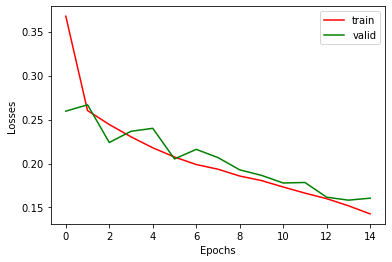

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(train_stats.losses, 'r', label='train')
plt.plot(test_stats.losses, 'g', label='valid')
plt.legend()
plt.show()

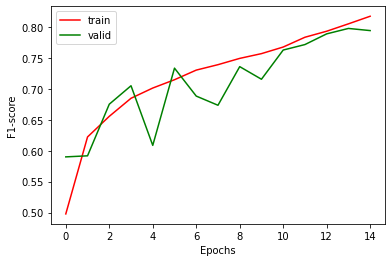

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.plot(train_stats.F1, 'r', label='train')
plt.plot(test_stats.F1, 'g', label='valid')
plt.legend()
plt.show()

In [ ]:
def pred_single(img, return_label=True):
    with torch.no_grad():
        model.eval()
        bs_img = img.unsqueeze(0)
        bs_img = bs_img.to(device)
        preds = torch.sigmoid(model(bs_img))
        prediction = preds[0]
        display_img(img, prediction, return_label)

In [ ]:
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'

In [ ]:
test_df = pd.read_csv(TEST_CSV)

In [ ]:
test_ds = ProteinDataset(TEST_DIR, test_df, test_tf)

In [ ]:
img, label = test_ds[100]

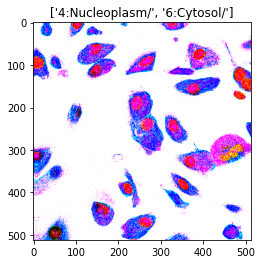

In [ ]:
pred_single(img)

In [ ]:
test_loader = DataLoader(test_ds, bs, num_workers=4, pin_memory=True)

In [ ]:
load_checkpoint(model, './best_model.pth')

In [ ]:
def predict(loader):
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()
        preds = []
        t = tqdm(loader, leave=False, total=len(loader))
        for i, (ip, _) in enumerate(t):
            ip = ip.to(device)
            output = torch.sigmoid(model(ip))
            preds.append(output.cpu().detach())
        preds = torch.cat(preds)
        return [" ".join(decode_labels(pred)) for pred in preds]

In [ ]:
preds = predict(test_loader)

In [ ]:
len(preds), len(test_df)

(8243, 8243)

In [ ]:
preds

['4 8 9',
 '4',
 '6',
 '3 6',
 '3 4',
 '1',
 '0',
 '3 6',
 '4',
 '9',
 '9',
 '4 7',
 '3 4',
 '7',
 '3 4',
 '5',
 '1',
 '4 8',
 '9',
 '4 7',
 '2 4',
 '4',
 '7',
 '4 5 6 7',
 '4 6',
 '4 7',
 '4 7',
 '4 6',
 '1',
 '5 6',
 '4',
 '4',
 '4 6 7',
 '3 4',
 '0',
 '4',
 '7',
 '4',
 '6',
 '4 6',
 '4',
 '1',
 '3',
 '6',
 '4 6',
 '4 7',
 '2 7',
 '4',
 '0',
 '3',
 '6',
 '2',
 '9',
 '4 7',
 '0',
 '4',
 '4',
 '6',
 '9',
 '1 4',
 '2 4',
 '6',
 '0',
 '3 4',
 '2 4 6',
 '5',
 '3 5',
 '0',
 '0 4',
 '6 7',
 '9',
 '',
 '8',
 '0 4',
 '0 3',
 '4',
 '2 4',
 '4',
 '4 6',
 '5',
 '',
 '4 6',
 '4 6',
 '2 4',
 '9',
 '3',
 '2',
 '2',
 '2 4',
 '4',
 '3',
 '1',
 '5',
 '4 6',
 '2 3',
 '0',
 '4',
 '4',
 '6',
 '1',
 '4 6',
 '8',
 '6 9',
 '7',
 '4',
 '4',
 '2 4',
 '1 6',
 '0',
 '2 3',
 '3',
 '6 7',
 '',
 '4',
 '0',
 '9',
 '4',
 '1',
 '0',
 '4',
 '3',
 '6 7',
 '9',
 '4 6',
 '3',
 '',
 '4 6',
 '6',
 '0',
 '9',
 '2',
 '2',
 '0',
 '7',
 '0',
 '4 6',
 '3 4',
 '2',
 '0',
 '0',
 '1 6',
 '4',
 '0 4',
 '2',
 '2',
 '8',
 '4',
 '4',


In [ ]:
sub_df = pd.read_csv(TEST_CSV)

In [ ]:
sub_df.head()

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0


In [ ]:
sub_df['Label'] = preds

In [ ]:
sub_df.head()

,Image,Label
0,24117,4 8 9
1,15322,4
2,14546,6
3,8079,3 6
4,13192,3 4


In [ ]:
sub_df.to_csv('submission.csv', index=False)